In [1]:
%matplotlib inline
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

def plotPlayer(id):
    player = id
    fig = plt.figure(figsize=(10, 6))
    ax = fig.gca()
    df[df['id'] == player][['wrating', 'age']].set_index('age').sort_index().plot(ax=ax)
    df[df['id'] == player][['rating', 'age']].set_index('age').sort_index().plot(ax=ax)
    return (df[df['id'] == player][['wrating', 'tour', 'age', 'team', 'start']].set_index('age').sort_index())

In [2]:
def load_csv(system):
    df = pd.read_csv(system + '.csv', encoding="utf-8")
    df.start = pd.to_datetime(df.start, format='%d/%m/%Y')
    df.end = pd.to_datetime(df.end, format='%d/%m/%Y')
    dob = pd.read_csv('dob.csv', encoding="utf-8")
    dob.id = dob.id.str.replace(r'\W+', '').str.lower()
    return df, dob

def cumulativeRating(diff, ratingName, df):
    cumsums = df[['id', 'start', diff]].groupby(['id', 'start']).sum().groupby(level=0).cumsum()
    df = df.set_index(['id', 'start'])
    df['cumur'] = cumsums
    df = df.reset_index()
    init = df[df['startglicko2rating'].notnull()].sort_values('start')[['startglicko2rating', 'id']].groupby('id').first().reset_index().rename(columns={'startglicko2rating': 'init'})
    df = pd.merge(df, init, how='left', on='id')
    df[ratingName] = df.cumur + df.init
    return df

def teamRating(rating, df):
    teameff = df.merge((df.groupby(['team', 'start']).mean()[rating] * 5).reset_index().rename(columns={rating: 'teamrating'}), on=['team', 'start'])
    teameff.teamrating = (teameff.teamrating - teameff[rating]) / 4
    return teameff

def experience(df):
    dfid2 = pd.DataFrame()
    for player in df.id.unique():
        dfid = pd.DataFrame(df[df['id'] == player].sort_values('start').tour.unique()).reset_index().rename(columns={'index': 'exp', 0: 'tour'})
        dfid['id'] = player
        dfid2 = pd.concat([dfid2, dfid])
    return pd.merge(df, dfid2, how='left', on=['id', 'tour'])
    
def dobMerge(df, dob):
    dob.id = dob.id.str.replace(r'\W+', '').str.lower()
    df = df.merge(dob, how='left', on=['id'])
    df.dob = pd.to_datetime(df.dob, format='%Y/%m/%d')
    df['age'] = (df.start - df.dob) / pd.Timedelta(days=365.25)
    return df

In [3]:
df, dob = load_csv('glicko2')
df['diffr'] = df.endglicko2rating - df.startglicko2rating
df = cumulativeRating('diffr', 'normalRating', df)
df = teamRating('normalRating', df)
df = experience(df)
df.drop_duplicates(subset=['id', 'start'], inplace=True)
df.dropna(inplace=True)
df = dobMerge(df, dob)
df.dropna(inplace=True)
df = df[(df.prizeusd != 'Nan')]
df.prizeusd = pd.to_numeric(df.prizeusd)

In [4]:
df['season'] = 'ti3'
df.loc[(df.start > pd.to_datetime('2013-08-02')) & (df.start <= pd.to_datetime('2014-07-08')), 'season'] = 'ti4'
df.loc[(df.start > pd.to_datetime('2014-07-08')) & (df.start <= pd.to_datetime('2015-07-27')), 'season'] = 'ti5'
df.loc[(df.start > pd.to_datetime('2015-07-27')) & (df.start <= pd.to_datetime('2016-08-02')), 'season'] = 'ti6'
df.loc[(df.start > pd.to_datetime('2016-08-02')) & (df.start <= pd.to_datetime('2017-08-02')), 'season'] = 'ti7'

In [5]:
df['tiprize'] = np.log(int(df[df['tour'] == 'The International 2013'].prizeusd.iloc[0]))
df.loc[(df.season == 'ti4'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2014'].prizeusd.iloc[0]))
df.loc[(df.season == 'ti5'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2015'].prizeusd.iloc[0]))
df.loc[(df.season == 'ti6'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2016'].prizeusd.iloc[0]))
df.loc[(df.season == 'ti7'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2017'].prizeusd.iloc[0]))

df['wdiffr'] = (df.prizeusd.apply(np.log) / df.tiprize) * df.diffr

#cumulative sum of wdiffr
cumsums = df[['id', 'start', 'wdiffr']].groupby(['id', 'start']).sum().groupby(level=0).cumsum()
df = df.set_index(['id', 'start'])
df['cumuwr'] = cumsums
df = df.reset_index()
df['wrating'] = df.cumuwr + df.init

In [6]:
ent = pd.DataFrame(df.id.unique()).reset_index().rename(columns={'index': 'entity', 0: 'id'})
df = ent.merge(df, on='id', how='left')

In [7]:
def panelOLSResult(df, Y, X):
    from linearmodels import PanelOLS 
    panel_data = df.set_index(['entity', 'start']).sort_index()
    panel_data['agesq'] = panel_data.age ** 2
    panel_data['const'] = 1
    panel_data['lexp'] = (panel_data['exp'] + 1).apply(np.log)
    Y = panel_data[Y]
    X = panel_data[X]
    mod = PanelOLS(Y, X, entity_effects=True)
    return mod.fit()

def feResult(res):
    fe = res.estimated_effects.reset_index().drop_duplicates().drop_duplicates(subset=['entity']).drop('time', 1)
    return ent.merge(fe, on='entity').sort_values('estimated_effects', ascending=False)

### Age and experience

In [8]:
df[['wrating', 'age', 'exp']].describe()

,wrating,age,exp
count,5251.000000,5251.000000,5251.000000
mean,1759.784722,22.611274,24.626357
std,175.103877,2.527670,17.632583
min,1281.650952,15.739904,0.000000
25%,1637.702582,20.882957,11.000000
50%,1739.296889,22.666667,21.000000
75%,1865.689863,24.394251,36.000000
max,2275.313145,30.149213,83.000000


In [9]:
res = panelOLSResult(df, 'wrating', ['age', 'agesq', 'lexp'])

In [10]:
res.summary

Dep. Variable:,wrating,R-squared:,0.2819
Estimator:,PanelOLS,R-squared (Between):,0.9929
No. Observations:,5251,R-squared (Within):,0.2819
Date:,"Tue, Feb 27 2018",R-squared (Overall):,0.9916
Time:,15:02:46,Log-likelihood,-3.04e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,650.30
Entities:,278,P-value,0.0000
Avg Obs:,18.888,Distribution:,"F(3,4970)"
Min Obs:,1.0000,,
Max Obs:,76.000,F-statistic (robust):,650.30


## $wrating = -2.6996*age^2+130.57*age+65.331*log(lexp)$
### $peakage: 24.18$

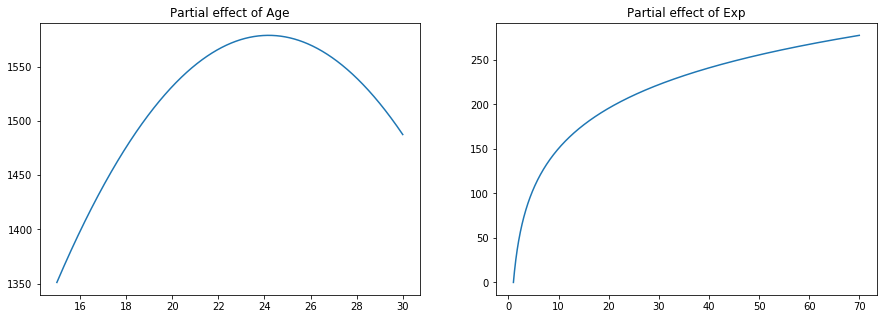

In [11]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
expx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex 
exp = res.params.lexp*np.log(expx)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, age)
ax[0].set_title("Partial effect of Age")
ax[1].plot(expx, exp)
ax[1].set_title("Partial effect of Exp")
plt.show()

### Teammate effect
teamrating = (average rating of all player in that team at that tournament * 5) - (that player rating)

In [26]:
df[['wrating', 'age', 'exp', 'teamrating']].describe()

,wrating,age,exp,teamrating
count,5251.000000,5251.000000,5251.000000,5251.000000
mean,1759.784722,22.611274,24.626357,1840.911627
std,175.103877,2.527670,17.632583,192.464997
min,1281.650952,15.739904,0.000000,1321.284974
25%,1637.702582,20.882957,11.000000,1705.510679
50%,1739.296889,22.666667,21.000000,1831.697828
75%,1865.689863,24.394251,36.000000,1975.672821
max,2275.313145,30.149213,83.000000,2413.802158


In [27]:
res = panelOLSResult(df, 'wrating', ['age', 'agesq', 'lexp', 'teamrating'])

In [28]:
res.summary

Dep. Variable:,wrating,R-squared:,0.4509
Estimator:,PanelOLS,R-squared (Between):,0.6550
No. Observations:,5251,R-squared (Within):,0.4509
Date:,"Tue, Feb 27 2018",R-squared (Overall):,0.7109
Time:,15:12:37,Log-likelihood,-2.97e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1019.9
Entities:,278,P-value,0.0000
Avg Obs:,18.888,Distribution:,"F(4,4969)"
Min Obs:,1.0000,,
Max Obs:,76.000,F-statistic (robust):,1019.9


## $wrating = -2.816*age^2+157.62*age+18.362*log(lexp)+0.2909*teammaterating$
### $peak age: 27.98$

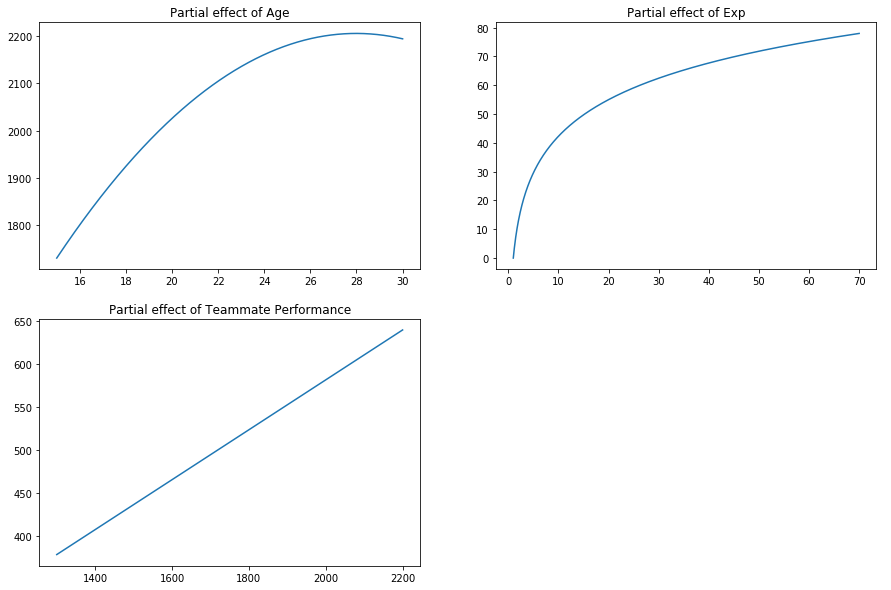

In [29]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
expx = np.linspace(1, 70, 1000)
teamx = np.linspace(1300, 2200, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex 
exp = res.params.lexp*np.log(expx)
team = res.params.teamrating*teamx 

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].plot(agex, age)
ax[0, 0].set_title("Partial effect of Age")
ax[0, 1].plot(expx, exp)
ax[0, 1].set_title("Partial effect of Exp")
ax[1, 0].plot(teamx, team)
ax[1, 0].set_title("Partial effect of Teammate Performance")
ax[1, 1].axis('off')

plt.show()

### Team Performance = glickorating

In [30]:
df[['wrating', 'age', 'exp', 'startglicko2rating']].describe()

,wrating,age,exp,startglicko2rating
count,5251.000000,5251.000000,5251.000000,5251.000000
mean,1759.784722,22.611274,24.626357,1726.679155
std,175.103877,2.527670,17.632583,106.350814
min,1281.650952,15.739904,0.000000,1326.826060
25%,1637.702582,20.882957,11.000000,1654.136217
50%,1739.296889,22.666667,21.000000,1736.664223
75%,1865.689863,24.394251,36.000000,1806.224329
max,2275.313145,30.149213,83.000000,1952.785682


In [31]:
res = panelOLSResult(df, 'wrating', ['age', 'agesq', 'lexp', 'startglicko2rating'])

In [32]:
res.summary

Dep. Variable:,wrating,R-squared:,0.3826
Estimator:,PanelOLS,R-squared (Between):,0.9704
No. Observations:,5251,R-squared (Within):,0.3826
Date:,"Tue, Feb 27 2018",R-squared (Overall):,0.9764
Time:,15:12:42,Log-likelihood,-3.001e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,769.72
Entities:,278,P-value,0.0000
Avg Obs:,18.888,Distribution:,"F(4,4969)"
Min Obs:,1.0000,,
Max Obs:,76.000,F-statistic (robust):,769.72


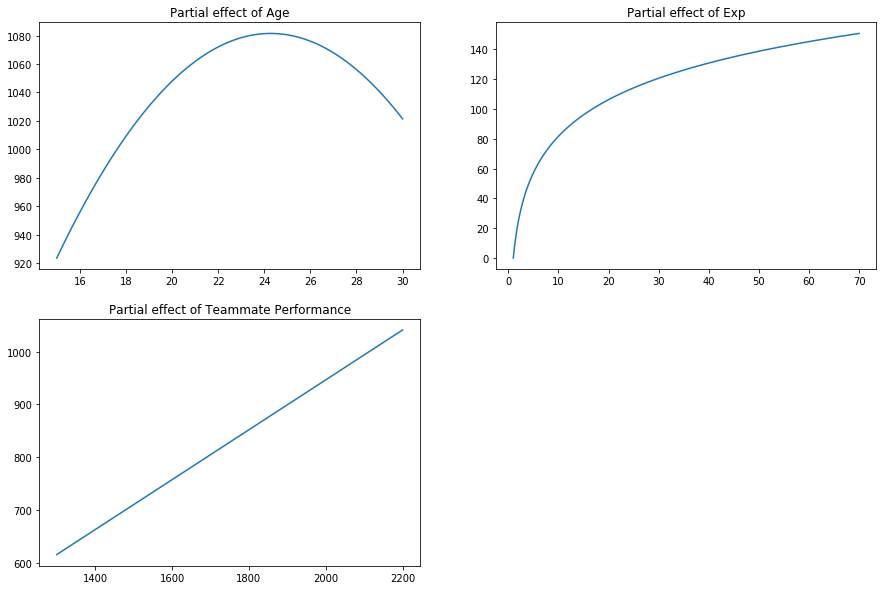

In [35]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
expx = np.linspace(1, 70, 1000)
teamx = np.linspace(1300, 2200, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex 
exp = res.params.lexp*np.log(expx)
team = res.params.startglicko2rating*teamx 

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].plot(agex, age)
ax[0, 0].set_title("Partial effect of Age")
ax[0, 1].plot(expx, exp)
ax[0, 1].set_title("Partial effect of Exp")
ax[1, 0].plot(teamx, team)
ax[1, 0].set_title("Partial effect of Teammate Performance")
ax[1, 1].axis('off')

plt.show()

In [41]:
df[['age', 'wrating', 'startglicko2rating', 'teamrating']].corr()

,age,wrating,startglicko2rating,teamrating
age,1.000000,0.032960,0.114025,0.044098
wrating,0.032960,1.000000,0.493680,0.574158
startglicko2rating,0.114025,0.493680,1.000000,0.600692
teamrating,0.044098,0.574158,0.600692,1.000000


In [57]:
from linearmodels import PanelOLS
panel_data = df.set_index(['entity', 'start']).sort_index()
panel_data['agesq'] = panel_data.age ** 2
panel_data['const'] = 1
panel_data['lexp'] = (panel_data['exp'] + 1).apply(np.log)
Y = panel_data['wrating']
X = panel_data[['age', 'agesq', 'const']]
mod = PanelOLS(Y, X, entity_effects=True)
res =  mod.fit()

In [58]:
res.summary

Dep. Variable:,wrating,R-squared:,0.2264
Estimator:,PanelOLS,R-squared (Between):,-1.0174
No. Observations:,5251,R-squared (Within):,0.2264
Date:,"Tue, Feb 27 2018",R-squared (Overall):,-0.4562
Time:,15:34:59,Log-likelihood,-3.06e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,727.45
Entities:,278,P-value,0.0000
Avg Obs:,18.888,Distribution:,"F(2,4971)"
Min Obs:,1.0000,,
Max Obs:,76.000,F-statistic (robust):,727.45


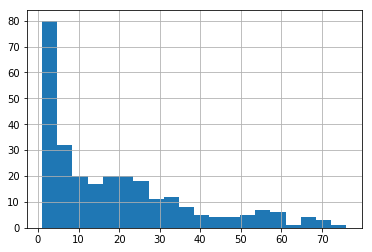

In [67]:
df.groupby('entity').size().hist(bins=20)

In [303]:
bal = df.copy()

In [304]:
bal['start'] = bal[bal['tour'] == 'The International 2013'].end.iloc[0]
bal.loc[(bal.season == 'ti4'), 'start'] = bal[bal['tour'] == 'The International 2014'].end.iloc[0]
bal.loc[(bal.season == 'ti5'), 'start'] = bal[bal['tour'] == 'The International 2015'].end.iloc[0]
bal.loc[(bal.season == 'ti6'), 'start'] = bal[bal['tour'] == 'The International 2016'].end.iloc[0]
bal.loc[(bal.season == 'ti7'), 'start'] = bal[bal['tour'] == 'The International 2017'].end.iloc[0]

In [305]:
bal['age'] = (bal.start- bal.dob) / pd.Timedelta(days=365.25)

In [306]:
bal = bal.groupby(['id', 'season'], as_index=False).agg(
                      {'wrating':['mean'],'age':'first', 'start':'first', 'exp': 'size', 'startglicko2rating': 'mean', 'teamrating': 'mean'})

In [307]:
nss = df.drop_duplicates(['id', 'season']).groupby(['id']).size().reset_index()

In [308]:
bal = bal[bal['id'].isin(nss[nss[0] >= 3].id.unique())]

In [309]:
bal.age = bal.age.round()

In [310]:
bal.columns = bal.columns.droplevel(level=1)

In [311]:
len(bal.id.unique())

118

In [312]:
ent = pd.DataFrame(bal.id.unique()).reset_index().rename(columns={'index': 'entity', 0: 'id'})
bal = ent.merge(bal, on='id', how='left')

In [313]:
bal.sample(5)

,entity,id,season,wrating,age,start,exp,startglicko2rating,teamrating
270,69,mikasa,ti5,1705.261477,29.0,2015-08-08,1,1737.769307,1808.040255
33,9,black,ti3,1689.362772,20.0,2013-08-11,22,1558.807098,1750.877271
113,29,fata,ti3,1700.459719,20.0,2013-08-11,20,1559.225718,1765.706864
424,111,xboct,ti6,1770.545598,26.0,2016-08-13,6,1712.001228,1778.657599
112,28,faith,ti7,2090.373919,26.0,2017-08-12,19,1862.690267,1805.303745


In [314]:
bal.describe()

,entity,wrating,age,exp,startglicko2rating,teamrating
count,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000
mean,57.825893,1749.771459,23.580357,8.977679,1706.653664,1819.365139
std,34.042624,179.848131,2.539666,5.642555,100.081045,173.750293
min,0.000000,1286.251001,16.000000,1.000000,1326.826060,1321.284974
25%,28.000000,1626.240228,22.000000,4.000000,1636.358314,1697.234963
50%,56.500000,1727.666513,24.000000,8.000000,1712.159848,1818.364497
75%,87.250000,1854.766220,25.000000,13.000000,1776.225914,1924.395779
max,117.000000,2259.896496,31.000000,23.000000,1915.703707,2259.458470


In [321]:
from linearmodels import PanelOLS 
panel_data = bal.set_index(['entity', 'start']).sort_index()
panel_data['agesq'] = panel_data.age ** 2
panel_data['const'] = 1
panel_data['lexp'] = (panel_data['exp'] + 1).apply(np.log)
Y = panel_data['wrating']
X = panel_data[['age', 'agesq', 'lexp', 'startglicko2rating', 'const']]
mod = PanelOLS(Y, X, entity_effects=True)
res = mod.fit()

In [322]:
res.summary

Dep. Variable:,wrating,R-squared:,0.3862
Estimator:,PanelOLS,R-squared (Between):,-0.1258
No. Observations:,448,R-squared (Within):,0.3862
Date:,"Tue, Feb 27 2018",R-squared (Overall):,-0.0253
Time:,20:00:43,Log-likelihood,-2527.0
Cov. Estimator:,Unadjusted,,
,,F-statistic:,51.280
Entities:,118,P-value,0.0000
Avg Obs:,3.7966,Distribution:,"F(4,326)"
Min Obs:,3.0000,,
Max Obs:,5.0000,F-statistic (robust):,51.280


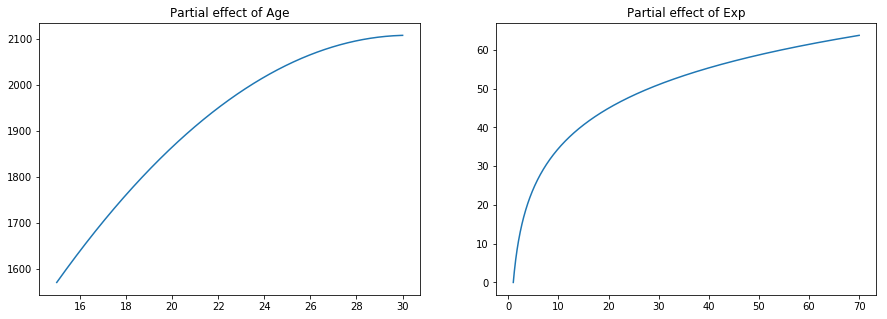

In [323]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
expx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex
exp = res.params.lexp*np.log(expx)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, age)
ax[0].set_title("Partial effect of Age")
ax[1].plot(expx, exp)
ax[1].set_title("Partial effect of Exp")
plt.show()

In [318]:
res.estimated_effects

estimated_effects
entity time                         
0      2013-08-11         -89.215738
       2014-07-21         -89.215738
       2015-08-08         -89.215738
1      2015-08-08          -4.382416
       2016-08-13          -4.382416
       2017-08-12          -4.382416
2      2013-08-11        -293.806475
       2014-07-21        -293.806475
       2017-08-12        -293.806475
3      2013-08-11         -93.659143
       2014-07-21         -93.659143
       2015-08-08         -93.659143
       2016-08-13         -93.659143
       2017-08-12         -93.659143
4      2015-08-08         -55.717007
       2016-08-13         -55.717007
       2017-08-12         -55.717007
5      2013-08-11        -125.774440
       2014-07-21        -125.774440
       2015-08-08        -125.774440
       2016-08-13        -125.774440
6      2015-08-08         227.433249
       2016-08-13         227.433249
       2017-08-12         227.433249
7      2014-07-21          11.152686
       2015-08-08          11.152686
       2016-08-13          11.152686
       2017-08-12          11.152686
8      2013-08-11         364.495459
       2014-07-21         364.495459
...                              ...
110    2013-08-11         -11.866766
       2014-07-21         -11.866766
       2015-08-08         -11.866766
111    2013-08-11         -31.066250
       2014-07-21         -31.066250
       2015-08-08         -31.066250
       2016-08-13         -31.066250
112    2013-08-11         156.852525
       2014-07-21         156.852525
       2015-08-08         156.852525
       2016-08-13         156.852525
       2017-08-12         156.852525
113    2013-08-11        -284.889472
       2014-07-21        -284.889472
       2015-08-08        -284.889472
114    2015-08-08         -93.399632
       2016-08-13         -93.399632
       2017-08-12         -93.399632
115    2013-08-11         159.904173
       2014-07-21         159.904173
       2015-08-08         159.904173
       2016-08-13         159.904173
       2017-08-12         159.904173
116    2014-07-21         482.550590
       2015-08-08         482.550590
       2016-08-13         482.550590
       2017-08-12         482.550590
117    2014-07-21        -205.432089
       2015-08-08        -205.432089
       2016-08-13        -205.432089

[448 rows x 1 columns]